In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls /content/drive/MyDrive/IU/reinforcement_learning/v8/checkpoints

/content/drive/MyDrive/IU/reinforcement_learning/v6/checkpoints


In [ ]:
!apt-get update
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install ale-py
!pip install torch torchvision torchaudio moviepy matplotlib

import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import random
import math
from pathlib import Path
from datetime import datetime
import json
import pickle
import gc
import psutil

# Directories
checkpoint_dir = Path('/content/drive/MyDrive/IU/reinforcement_learning/v8/checkpoints')
logs_dir = Path('/content/drive/MyDrive/IU/reinforcement_learning/v8/logs')
checkpoint_dir.mkdir(exist_ok=True)
logs_dir.mkdir(exist_ok=True)

# --- Environment ---
env = gym.make('ALE/Pong-v5', render_mode='rgb_array', frameskip=1)
env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=False, terminal_on_life_loss=True)
env = FrameStackObservation(env, stack_size=4)

num_state_feats = env.observation_space.shape
num_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}, state shape: {num_state_feats}, actions: {num_actions}")

# --- Dueling DQN ---
class DuelingDQN(nn.Module):
    """Convolutional neural network for the Atari games."""
    def __init__(self, num_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        std = math.sqrt(2.0 / (4 * 84 * 84))
        nn.init.normal_(self.conv1.weight, 0.0, std)
        self.conv1.bias.data.fill_(0.0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        std = math.sqrt(2.0 / (32 * 4 * 8 * 8))
        nn.init.normal_(self.conv2.weight, 0.0, std)
        self.conv2.bias.data.fill_(0.0)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        std = math.sqrt(2.0 / (64 * 32 * 4 * 4))
        nn.init.normal_(self.conv3.weight, 0.0, std)
        self.conv3.bias.data.fill_(0.0)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        std = math.sqrt(2.0 / (64 * 64 * 3 * 3))
        nn.init.normal_(self.fc1.weight, 0.0, std)
        self.fc1.bias.data.fill_(0.0)

        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, num_actions)

    def forward(self, x):
        """Forward pass of the neural network with some inputs."""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1))) # Flatten input.
        V = self.V(x)
        A = self.A(x)
        return V + (A - A.mean(dim=1, keepdim=True))

# Create main and target neural networks.
main_nn = DuelingDQN(num_actions).to(device)
target_nn = DuelingDQN(num_actions).to(device)

# Loss function and optimizer.
optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-5)
loss_fn = nn.SmoothL1Loss() # Huber loss

# --- Epsilon-greedy ---
def select_epsilon_greedy_action(state, epsilon):
    """Take random action with probability epsilon, else take best action."""
    if np.random.rand() < epsilon:
        return env.action_space.sample() # Random action.
    with torch.no_grad():
        qs = main_nn(state).cpu().numpy()
    return int(np.argmax(qs))

# --- Replay Buffer ---
class UniformBuffer:
    """Experience replay buffer that samples uniformly."""
    def __init__(self, size, device):
        self._size = size
        self.buffer = []
        self.device = device
        self._next_idx = 0

    def add(self, state, action, reward, next_state, done):
        if state.dtype != np.uint8:
            state = (state * 255).astype(np.uint8) if state.max() <= 1.0 else state.astype(np.uint8)
        if next_state.dtype != np.uint8:
            next_state = (next_state * 255).astype(np.uint8) if next_state.max() <= 1.0 else next_state.astype(np.uint8)

        # Make sure we're not storing unnecessary copies
        state_compact = np.ascontiguousarray(state)
        next_state_compact = np.ascontiguousarray(next_state)

        if self._next_idx >= len(self.buffer):
            self.buffer.append((state_compact, action, reward, next_state_compact, done))
        else:
            self.buffer[self._next_idx] = (state_compact, action, reward, next_state_compact, done)
        self._next_idx = (self._next_idx + 1) % self._size

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        indices = np.random.choice(len(self.buffer), num_samples, replace=False)

        # Pre-allocate arrays for better memory efficiency
        states = np.empty((num_samples, 4, 84, 84), dtype=np.float32)
        next_states = np.empty((num_samples, 4, 84, 84), dtype=np.float32)
        actions = np.empty(num_samples, dtype=np.int64)
        rewards = np.empty(num_samples, dtype=np.float32)
        dones = np.empty(num_samples, dtype=np.float32)

        for idx, i in enumerate(indices):
            s, a, r, ns, d = self.buffer[i]
            states[idx] = s.astype(np.float32) / 255.0
            next_states[idx] = ns.astype(np.float32) / 255.0
            actions[idx] = a
            rewards[idx] = r
            dones[idx] = d

        # Convert to tensors
        states_tensor = torch.from_numpy(states).to(self.device)
        next_states_tensor = torch.from_numpy(next_states).to(self.device)
        actions_tensor = torch.from_numpy(actions).to(self.device)
        rewards_tensor = torch.from_numpy(rewards).to(self.device)
        dones_tensor = torch.from_numpy(dones).to(self.device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

# --- Training step with Double DQN ---
def train_step(states, actions, rewards, next_states, dones):
    next_qs_argmax = main_nn(next_states).argmax(dim=-1, keepdim=True)
    masked_next_qs = target_nn(next_states).gather(1, next_qs_argmax).squeeze()
    target = rewards + (1 - dones) * discount * masked_next_qs
    masked_qs = main_nn(states).gather(1, actions.unsqueeze(-1)).squeeze()
    loss = loss_fn(masked_qs, target.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# Hyperparameters
num_episodes = 5000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer_size = 25000
save_interval = 50
log_interval = 10

buffer = UniformBuffer(buffer_size, device)

# Training state
training_state = {'episode':0, 'epsilon':epsilon, 'cur_frame':0, 'last_100_ep_rewards':[], 'training_logs':{'episodes':[], 'rewards':[], 'avg_rewards':[], 'losses':[], 'epsilon_values':[], 'frames':[]}}

# Load from checkpoint if available
def load_latest_checkpoint():
    checkpoint_files = list(checkpoint_dir.glob("checkpoint_ep*.pth"))
    if not checkpoint_files:
        print("No checkpoints found. Starting from scratch.")
        return False

    # Find the latest checkpoint by episode number
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.stem.split('_')[1][2:]))
    print(f"Loading checkpoint: {latest_checkpoint}")

    try:
        with torch.serialization.safe_globals([np.core.multiarray.scalar]):
            checkpoint = torch.load(latest_checkpoint, map_location=device, weights_only=False)

        # Load model states
        main_nn.load_state_dict(checkpoint['main_nn_state_dict'])
        target_nn.load_state_dict(checkpoint['target_nn_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load training state
        global training_state
        training_state = checkpoint['training_state']
        checkpoint_filename = latest_checkpoint.name
        buffer_filename = f"buffer_{checkpoint_filename.replace('.pth', '.pkl')}"
        buffer_filepath = checkpoint_dir / buffer_filename

        if buffer_filepath.exists():
            print("Loading replay buffer...")
            with open(buffer_filepath, 'rb') as f:
                buffer.buffer = pickle.load(f)
                buffer._next_idx = len(buffer.buffer) % buffer._size
            print(f"Loaded buffer with {len(buffer.buffer)} experiences")
        else:
            print(f"No buffer file found at {buffer_filepath}, starting with empty buffer")

        print(f"Resumed from episode {checkpoint['episode']}, frame {training_state['cur_frame']}")
        return True

    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting from scratch.")
        return False

# Load checkpoint if available
checkpoint_loaded = load_latest_checkpoint()

# --- Checkpoints (with buffer size limit) ---
def save_checkpoint(episode, main_nn, target_nn, optimizer, buffer, training_state):
    filename = f"checkpoint_ep{episode}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    filepath = checkpoint_dir/filename
    checkpoint = {
        'episode': episode,
        'main_nn_state_dict': main_nn.state_dict(),
        'target_nn_state_dict': target_nn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_state': training_state
    }
    # Limit buffer saving
    buffer_filepath = checkpoint_dir/f"buffer_{filename.replace('.pth','.pkl')}"
    with open(buffer_filepath,'wb') as f:
        pickle.dump(buffer.buffer[:len(buffer)], f)  # Only save used portion

    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")
    return filepath

# --- Memory monitoring function ---
def print_memory_usage():
    print(f"RAM Usage: {psutil.virtual_memory().percent:.1f}%")
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.max_memory_allocated()/1024**3:.2f}GB")

last_100_ep_rewards = training_state['last_100_ep_rewards']
cur_frame = training_state['cur_frame']
epsilon = training_state['epsilon']
start_episode = training_state['episode']
loss_val = torch.tensor(0.0)

print(f"Starting training from episode {start_episode} with {len(buffer)} experiences in buffer...")
print_memory_usage()

# Start training. Play game once and then train with a batch.
for episode in range(start_episode + 1, num_episodes + 1):  # Start from next episode
    state, _ = env.reset()
    ep_reward, done = 0, False

    # Force garbage collection at episode start
    if episode % 25 == 0:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    while not done:
        # Convert state to tensor for action selection (minimize memory usage)
        state_tensor = torch.from_numpy(state.astype(np.float32) / 255.0).unsqueeze(0).to(device)
        action = select_epsilon_greedy_action(state_tensor, epsilon)

        # Clear the temporary tensor immediately
        del state_tensor

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        reward = np.sign(reward)

        # Store in buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
        if epsilon > 0.01:
            epsilon -= 1.1e-6

        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss_val = train_step(states, actions, rewards, next_states, dones)

            # Clear tensors after training step
            del states, actions, rewards, next_states, dones

        # Copy main_nn weights to target_nn.
        if cur_frame % 10000 == 0:
            target_nn.load_state_dict(main_nn.state_dict())

    if len(last_100_ep_rewards) == 100:
        last_100_ep_rewards.pop(0)
    last_100_ep_rewards.append(ep_reward)

    training_state.update({'episode':episode,'epsilon':epsilon,'cur_frame':cur_frame,'last_100_ep_rewards':last_100_ep_rewards})

    if episode % log_interval == 0:
        avg_reward = np.mean(last_100_ep_rewards) if last_100_ep_rewards else ep_reward
        logs = training_state['training_logs']
        logs['episodes'].append(episode)
        logs['rewards'].append(ep_reward)
        logs['avg_rewards'].append(avg_reward)
        logs['losses'].append(float(loss_val.item()) if isinstance(loss_val, torch.Tensor) else 0.0)
        logs['epsilon_values'].append(epsilon)
        logs['frames'].append(cur_frame)
        print(f"Ep {episode}/{num_episodes}, ε={epsilon:.3f}, Loss={float(loss_val.item()) if isinstance(loss_val, torch.Tensor) else 0.0:.4f}, AvgR={avg_reward:.2f}")
        print_memory_usage()

        with open(logs_dir/"latest_logs.json",'w') as f:
            json.dump(logs,f,indent=2)

    if episode % save_interval == 0:
        save_checkpoint(episode, main_nn, target_nn, optimizer, buffer, training_state)

    # Memory check
    if psutil.virtual_memory().percent > 85:
        print("WARNING: High memory usage detected. Forcing garbage collection...")
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print("Training completed!")
# Final save
save_checkpoint(training_state['episode'], main_nn, target_nn, optimizer, buffer, training_state)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,045 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,307 kB in 1s (1,996 kB/s)
Reading package lists... Done
W: Skipping acquire of con

In [ ]:
# --- Testing / Video Recording ---
import glob, io, base64
from IPython.display import HTML, display

def stack_frames_for_test(frames, num_stack=4):
    """Reconstruct a stack of last frames for testing (like in training)."""
    stacked = []
    for offset in reversed(range(num_stack)):
        i = len(frames) - 1 - offset
        if i < 0 or frames[i]['done']:
            stacked.append(np.zeros_like(frames[0]['frame'], dtype=np.uint8))
        else:
            stacked.append(frames[i]['frame'])
    return np.stack(stacked, axis=0)

def show_video_colab(video_dir='./video'):
    """Display the first recorded video in Colab without writing repeatedly."""
    mp4list = glob.glob(f'{video_dir}/*.mp4')
    if len(mp4list) == 0:
        print("No video found")
        return
    mp4 = mp4list[0]

    # Read entire video file
    with open(mp4, 'rb') as f:
        video_bytes = f.read()

    encoded = base64.b64encode(video_bytes)
    display(HTML(data=f"""
        <video alt="test" autoplay loop controls style="height:400px;">
        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
        </video>
    """))

# --- Run a test episode ---
test_env = gym.make('ALE/Pong-v5', render_mode='rgb_array', frameskip=1)
test_env = AtariPreprocessing(test_env, grayscale_obs=True, terminal_on_life_loss=False)
# Fixed: Use gymnasium.wrappers instead of gym.wrappers
test_env = gym.wrappers.RecordVideo(test_env, './video', episode_trigger=lambda x: True)

# Initialize frame stack like training: 3 blanks + first frame
state, _ = test_env.reset()
frame_stack = [np.zeros_like(state) for _ in range(3)] + [state]

done = False
total_reward = 0

while not done:
    # Construct stacked state
    stacked_state = np.stack(frame_stack[-4:], axis=0)
    state_tensor = torch.tensor(stacked_state, dtype=torch.float32, device=device).unsqueeze(0) / 255.0

    # Select greedy action
    action = select_epsilon_greedy_action(state_tensor, epsilon=0.01)

    next_state, reward, terminated, truncated, _ = test_env.step(action)
    total_reward += reward

    # Update frame stack
    frame_stack.append(next_state)
    done = terminated or truncated

print(f"Test Episode Total Reward: {total_reward}")
test_env.close()

show_video_colab()

NameError: name 'gym' is not defined

Loaded logs with 396 data points
Generating comprehensive evaluation plots...
Training progress plot saved to plots/training_progress.png


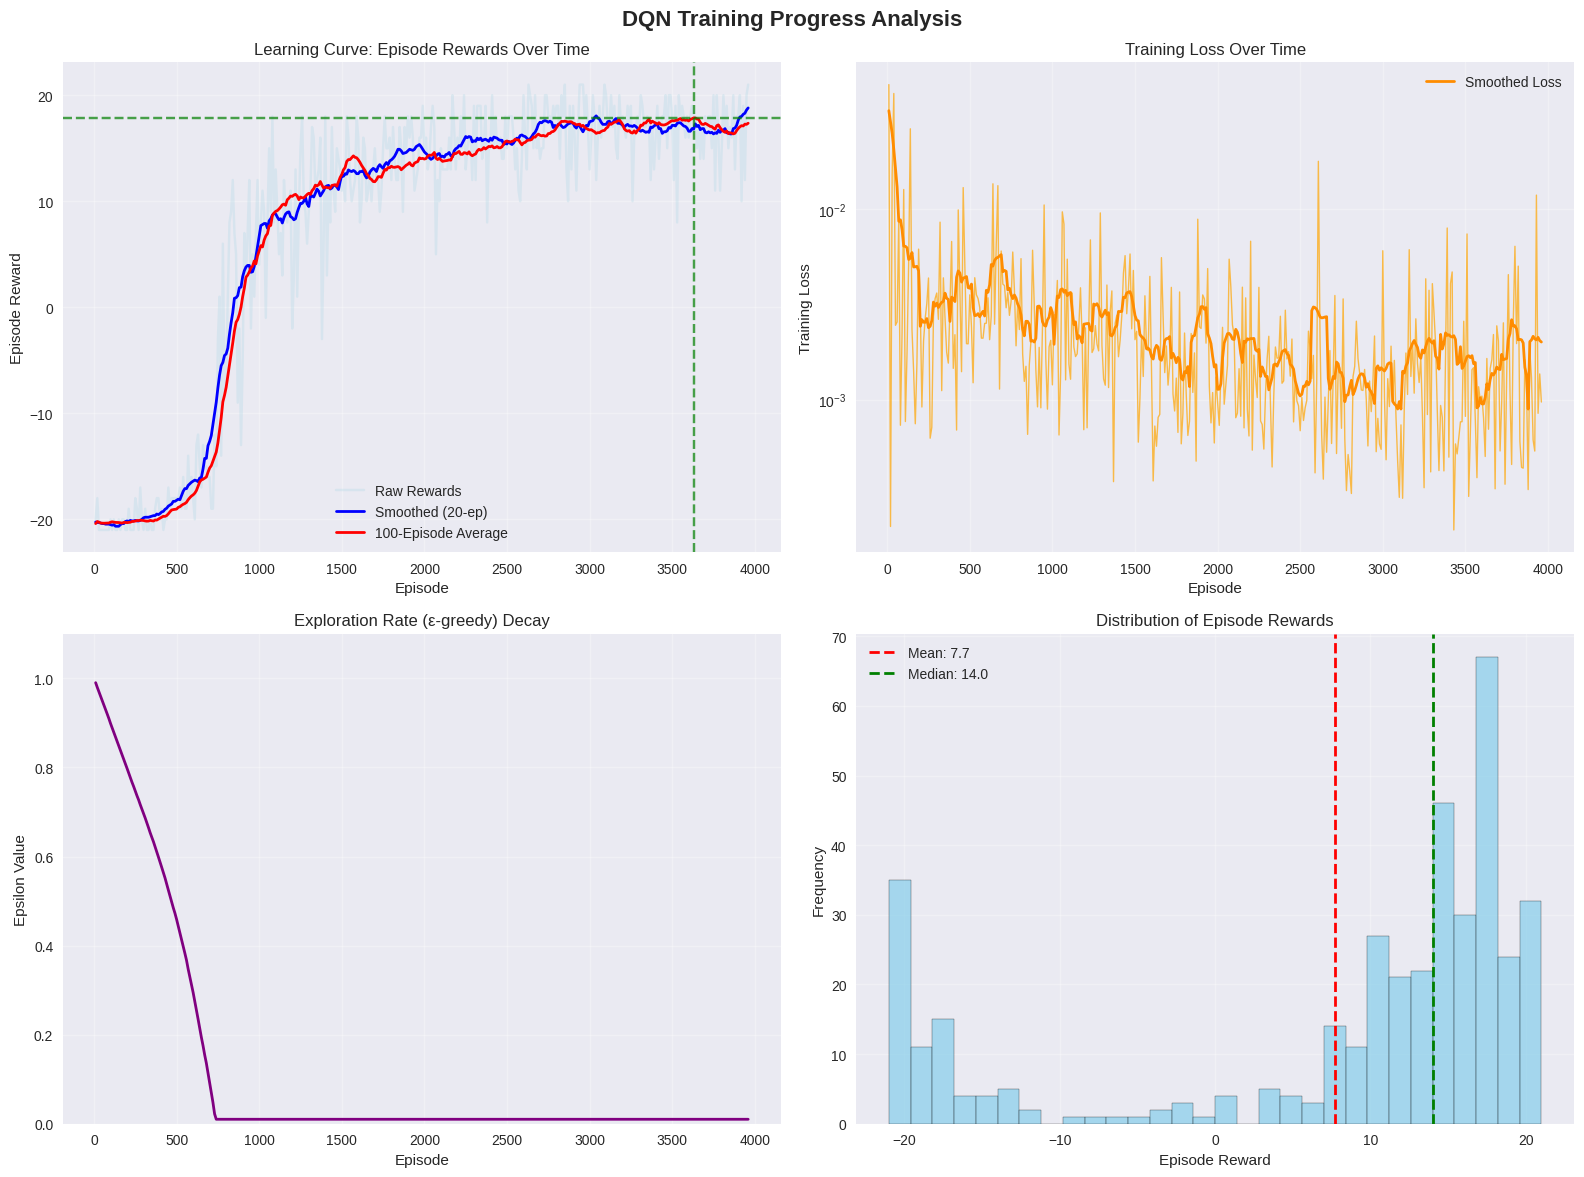

Learning phases plot saved to plots/learning_phases.png


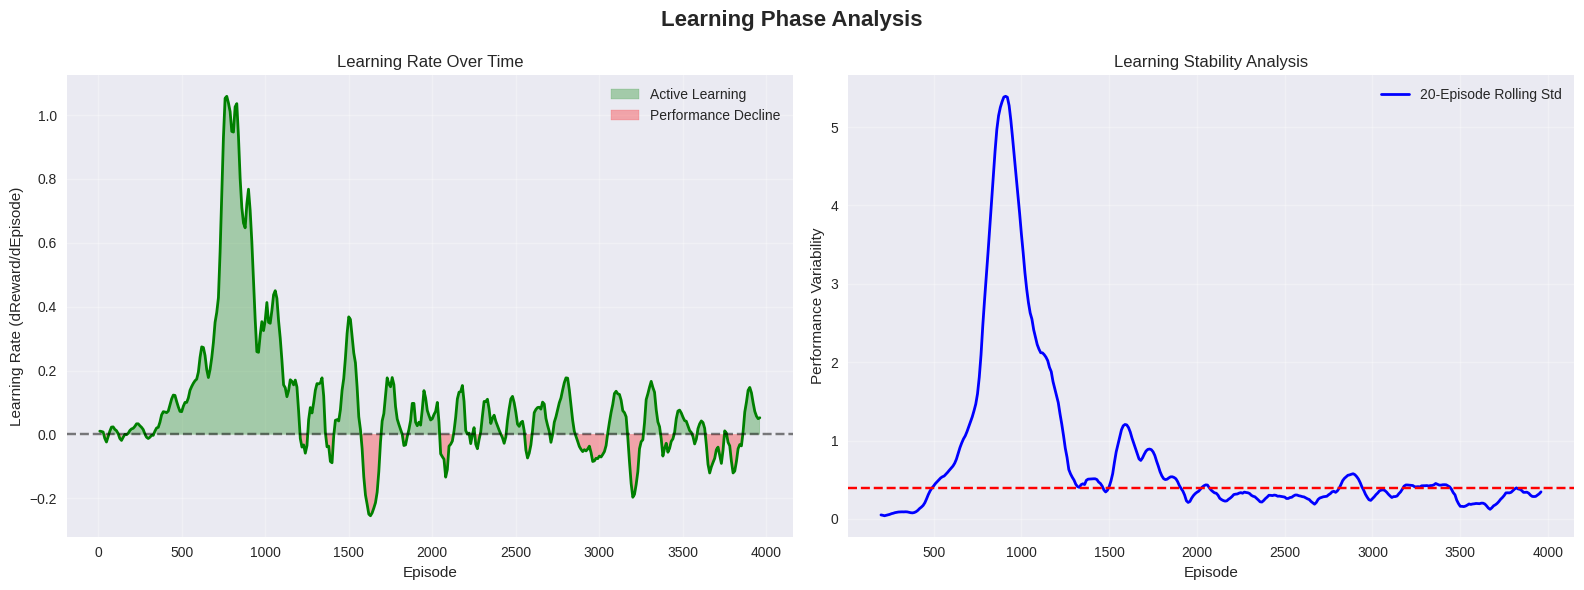

Sample efficiency plot saved to plots/sample_efficiency.png


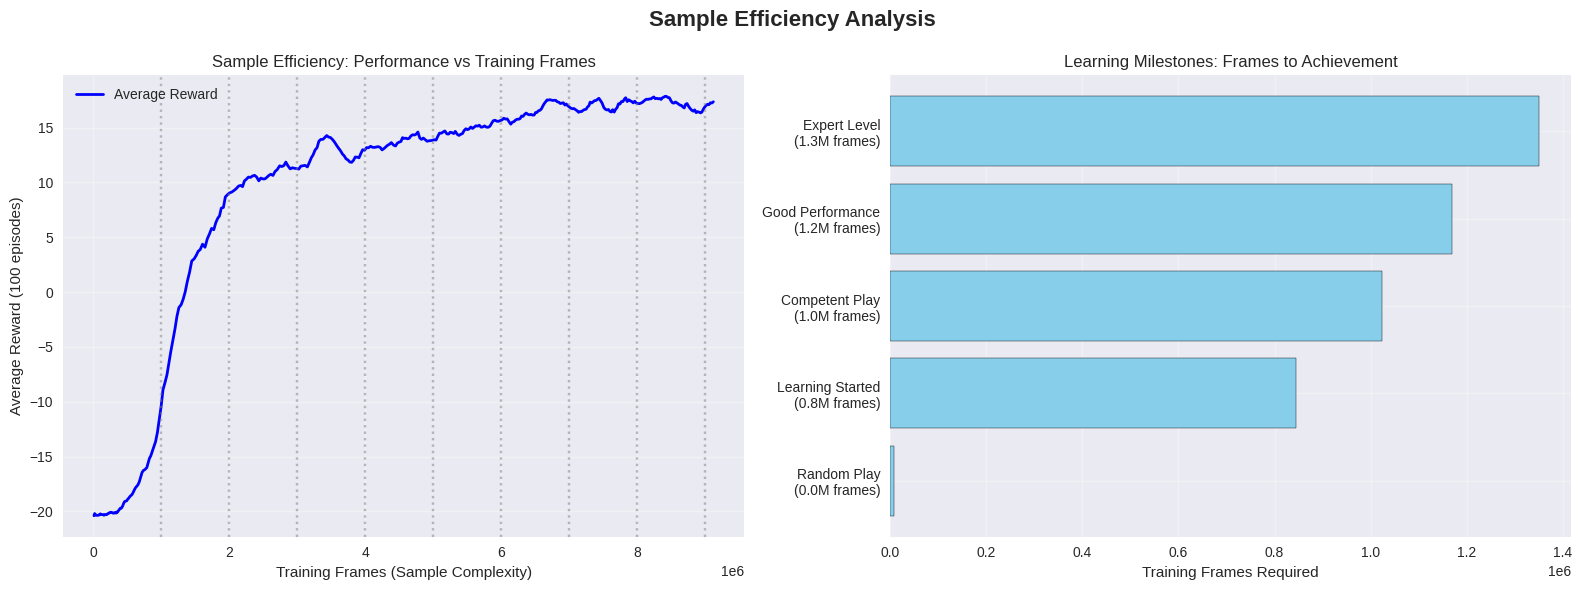

DQN MODEL PERFORMANCE REPORT
Training Episodes: 396
Total Training Frames: 9,116,152 (9.1M)

REWARD STATISTICS:
  Final Average Reward (100-ep): 17.36
  Best Average Reward: 17.86
  Overall Mean Reward: 7.75 ± 13.76
  Median Reward: 14.00
  Reward Range: [-21.0, 21.0]
  Performance Improvement: 37.27 (183.3%)
  Recent Stability (std of last 20): 0.34

LEARNING ANALYSIS:
  Best Learning Period: Episodes 710-910
  Max Improvement in 20 episodes: 9.27

SAMPLE EFFICIENCY MILESTONES:
  Reached -15 reward: 0.8M frames (Episode 710)
  Reached -10 reward: 1.0M frames (Episode 780)
  Reached -5 reward: 1.2M frames (Episode 830)
  Reached +0 reward: 1.3M frames (Episode 890)

All plots saved to plots


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy import stats

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

class DQNEvaluator:
    def __init__(self, logs_path):
        """Initialize evaluator with path to training logs."""
        self.logs_path = Path(logs_path)
        self.load_training_logs()

    def load_training_logs(self):
        """Load training logs from JSON file."""
        try:
            with open(self.logs_path / "latest_logs.json", 'r') as f:
                self.logs = json.load(f)
            print(f"Loaded logs with {len(self.logs['episodes'])} data points")
        except FileNotFoundError:
            print(f"No logs found at {self.logs_path}")
            self.logs = None

    def smooth_curve(self, data, window_size=10):
        """Apply smoothing to reduce noise in plots."""
        return uniform_filter1d(data, size=window_size, mode='nearest')

    def plot_training_progress(self, save_path=None):
        """Plot comprehensive training progress with multiple subplots."""
        if not self.logs:
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('DQN Training Progress Analysis', fontsize=16, fontweight='bold')

        episodes = np.array(self.logs['episodes'])
        rewards = np.array(self.logs['rewards'])
        avg_rewards = np.array(self.logs['avg_rewards'])
        losses = np.array(self.logs['losses'])
        epsilon = np.array(self.logs['epsilon_values'])

        # 1. Episode Rewards
        axes[0,0].plot(episodes, rewards, alpha=0.3, color='lightblue', label='Raw Rewards')
        axes[0,0].plot(episodes, self.smooth_curve(rewards, 20), color='blue', linewidth=2, label='Smoothed (20-ep)')
        axes[0,0].plot(episodes, avg_rewards, color='red', linewidth=2, label='100-Episode Average')
        axes[0,0].set_xlabel('Episode')
        axes[0,0].set_ylabel('Episode Reward')
        axes[0,0].set_title('Learning Curve: Episode Rewards Over Time')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Add performance milestones
        if len(avg_rewards) > 0:
            best_avg = np.max(avg_rewards)
            best_episode = episodes[np.argmax(avg_rewards)]
            axes[0,0].axhline(y=best_avg, color='green', linestyle='--', alpha=0.7,
                            label=f'Best Avg: {best_avg:.1f}')
            axes[0,0].axvline(x=best_episode, color='green', linestyle='--', alpha=0.7)

        # 2. Training Loss
        axes[0,1].plot(episodes, losses, color='orange', linewidth=1, alpha=0.7)
        axes[0,1].plot(episodes, self.smooth_curve(losses, 10), color='darkorange', linewidth=2, label='Smoothed Loss')
        axes[0,1].set_xlabel('Episode')
        axes[0,1].set_ylabel('Training Loss')
        axes[0,1].set_title('Training Loss Over Time')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_yscale('log')  # Log scale for loss

        # 3. Exploration vs Exploitation
        axes[1,0].plot(episodes, epsilon, color='purple', linewidth=2)
        axes[1,0].set_xlabel('Episode')
        axes[1,0].set_ylabel('Epsilon Value')
        axes[1,0].set_title('Exploration Rate (ε-greedy) Decay')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_ylim(0, 1.1)

        # 4. Performance Distribution
        axes[1,1].hist(rewards, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(np.mean(rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(rewards):.1f}')
        axes[1,1].axvline(np.median(rewards), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(rewards):.1f}')
        axes[1,1].set_xlabel('Episode Reward')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Distribution of Episode Rewards')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Training progress plot saved to {save_path}")
        plt.show()

    def plot_learning_phases(self, save_path=None):
        """Analyze different phases of learning."""
        if not self.logs:
            return

        episodes = np.array(self.logs['episodes'])
        avg_rewards = np.array(self.logs['avg_rewards'])

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Learning Phase Analysis', fontsize=16, fontweight='bold')

        # 1. Learning Rate Analysis
        if len(avg_rewards) > 10:
            # Calculate learning rate (derivative of performance)
            learning_rate = np.gradient(self.smooth_curve(avg_rewards, 5))

            axes[0].plot(episodes, learning_rate, color='green', linewidth=2)
            axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[0].set_xlabel('Episode')
            axes[0].set_ylabel('Learning Rate (dReward/dEpisode)')
            axes[0].set_title('Learning Rate Over Time')
            axes[0].grid(True, alpha=0.3)

            # Identify learning phases
            positive_learning = learning_rate > 0.01
            if np.any(positive_learning):
                axes[0].fill_between(episodes, learning_rate, 0,
                                   where=positive_learning, alpha=0.3, color='green',
                                   label='Active Learning')

            negative_learning = learning_rate < -0.01
            if np.any(negative_learning):
                axes[0].fill_between(episodes, learning_rate, 0,
                                   where=negative_learning, alpha=0.3, color='red',
                                   label='Performance Decline')
            axes[0].legend()

        # 2. Convergence Analysis
        if len(avg_rewards) > 50:
            # Rolling standard deviation to measure stability
            window_size = 20
            rolling_std = pd.Series(avg_rewards).rolling(window_size).std()

            axes[1].plot(episodes[window_size-1:], rolling_std[window_size-1:],
                        color='blue', linewidth=2, label=f'{window_size}-Episode Rolling Std')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Performance Variability')
            axes[1].set_title('Learning Stability Analysis')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()

            # Mark convergence point (when variability drops below threshold)
            convergence_threshold = np.mean(rolling_std[window_size:]) * 0.5
            axes[1].axhline(y=convergence_threshold, color='red', linestyle='--',
                          label=f'Convergence Threshold: {convergence_threshold:.2f}')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Learning phases plot saved to {save_path}")
        plt.show()

    def plot_sample_efficiency(self, save_path=None):
        """Analyze sample efficiency using frames instead of episodes."""
        if not self.logs or 'frames' not in self.logs:
            print("Frame data not available for sample efficiency analysis")
            return

        frames = np.array(self.logs['frames'])
        avg_rewards = np.array(self.logs['avg_rewards'])

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Sample Efficiency Analysis', fontsize=16, fontweight='bold')

        # 1. Performance vs Sample Complexity
        axes[0].plot(frames, avg_rewards, color='blue', linewidth=2, label='Average Reward')
        axes[0].set_xlabel('Training Frames (Sample Complexity)')
        axes[0].set_ylabel('Average Reward (100 episodes)')
        axes[0].set_title('Sample Efficiency: Performance vs Training Frames')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # Add million-frame markers
        for million in range(1, int(frames[-1]/1e6) + 1):
            axes[0].axvline(x=million*1e6, color='gray', linestyle=':', alpha=0.5,
                          label=f'{million}M frames' if million == 1 else "")

        # 2. Learning Milestones
        if len(avg_rewards) > 0:
            # Define performance milestones for Pong
            milestones = {
                'Random Play': -21,  # Worst possible in Pong
                'Learning Started': -15,
                'Competent Play': -10,
                'Good Performance': -5,
                'Expert Level': 0
            }

            milestone_frames = []
            milestone_names = []

            for name, threshold in milestones.items():
                # Find first episode where performance exceeded threshold
                exceeded = avg_rewards >= threshold
                if np.any(exceeded):
                    first_idx = np.where(exceeded)[0][0]
                    milestone_frames.append(frames[first_idx])
                    milestone_names.append(f"{name}\n({frames[first_idx]/1e6:.1f}M frames)")

            axes[1].barh(range(len(milestone_frames)), milestone_frames, color='skyblue', edgecolor='black')
            axes[1].set_yticks(range(len(milestone_frames)))
            axes[1].set_yticklabels(milestone_names)
            axes[1].set_xlabel('Training Frames Required')
            axes[1].set_title('Learning Milestones: Frames to Achievement')
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Sample efficiency plot saved to {save_path}")
        plt.show()

    def generate_performance_report(self):
        """Generate a comprehensive text report of model performance."""
        if not self.logs:
            return

        rewards = np.array(self.logs['rewards'])
        avg_rewards = np.array(self.logs['avg_rewards'])
        episodes = np.array(self.logs['episodes'])
        frames = np.array(self.logs['frames']) if 'frames' in self.logs else None

        print("="*60)
        print("DQN MODEL PERFORMANCE REPORT")
        print("="*60)

        print(f"Training Episodes: {len(episodes)}")
        if frames is not None:
            print(f"Total Training Frames: {frames[-1]:,} ({frames[-1]/1e6:.1f}M)")

        print("\nREWARD STATISTICS:")
        print(f"  Final Average Reward (100-ep): {avg_rewards[-1]:.2f}")
        print(f"  Best Average Reward: {np.max(avg_rewards):.2f}")
        print(f"  Overall Mean Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
        print(f"  Median Reward: {np.median(rewards):.2f}")
        print(f"  Reward Range: [{np.min(rewards):.1f}, {np.max(rewards):.1f}]")

        # Performance improvement
        if len(avg_rewards) > 10:
            early_performance = np.mean(avg_rewards[:10])
            late_performance = np.mean(avg_rewards[-10:])
            improvement = late_performance - early_performance
            print(f"  Performance Improvement: {improvement:.2f} ({improvement/abs(early_performance)*100:.1f}%)")

        # Learning stability
        recent_rewards = avg_rewards[-20:] if len(avg_rewards) >= 20 else avg_rewards
        stability = np.std(recent_rewards)
        print(f"  Recent Stability (std of last 20): {stability:.2f}")

        print("\nLEARNING ANALYSIS:")
        if len(avg_rewards) > 50:
            # Find best learning period
            window_size = 20
            improvements = []
            for i in range(len(avg_rewards) - window_size):
                start_avg = np.mean(avg_rewards[i:i+window_size//2])
                end_avg = np.mean(avg_rewards[i+window_size//2:i+window_size])
                improvements.append(end_avg - start_avg)

            best_period_idx = np.argmax(improvements)
            best_improvement = improvements[best_period_idx]
            print(f"  Best Learning Period: Episodes {episodes[best_period_idx]}-{episodes[best_period_idx+window_size]}")
            print(f"  Max Improvement in {window_size} episodes: {best_improvement:.2f}")

        # Sample efficiency milestones
        if frames is not None:
            milestones = [-15, -10, -5, 0]
            print(f"\nSAMPLE EFFICIENCY MILESTONES:")
            for milestone in milestones:
                exceeded = avg_rewards >= milestone
                if np.any(exceeded):
                    first_idx = np.where(exceeded)[0][0]
                    print(f"  Reached {milestone:+.0f} reward: {frames[first_idx]/1e6:.1f}M frames (Episode {episodes[first_idx]})")

        print("="*60)

    def create_all_plots(self, output_dir="./plots"):
        """Generate all evaluation plots and save them."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        print("Generating comprehensive evaluation plots...")

        # Generate all plots
        self.plot_training_progress(output_path / "training_progress.png")
        self.plot_learning_phases(output_path / "learning_phases.png")
        self.plot_sample_efficiency(output_path / "sample_efficiency.png")

        # Generate performance report
        self.generate_performance_report()

        print(f"\nAll plots saved to {output_path}")

# Usage example
if __name__ == "__main__":
    # Initialize evaluator with path to your logs directory
    logs_path = "/content/drive/MyDrive/IU/reinforcement_learning/v8/logs"  # Update this path

    evaluator = DQNEvaluator(logs_path)
    evaluator.create_all_plots()